<a href="https://colab.research.google.com/github/IngeborgOlssoen/Chagas-challenge-Hear-heart/blob/Slimmed-models/Chagas_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount to google drive

In [10]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Locate repo

In [11]:
%cd /content/drive/MyDrive/chagas-challenge
!ls



/content/drive/MyDrive/chagas-challenge
base_model.py	     model		       run_model.py
detailed_scores.csv  prepare_code15_data.py    scores.csv
Dockerfile	     prepare_ptbxl_data.py     script.py
evaluate_model.py    prepare_samitrop_data.py  splitting_data.py
helper_code.py	     __pycache__	       team_code.py
holdout_outputs      README.md		       train_model.py
LICENSE		     requirements.txt	       train_tmp.csv


# Installing and imports

## Installing

In [3]:
!pip install wfdb
!pip install -r requirements.txt
!pip install wfdb scikit-learn numpy pandas torch torchvision


## Imports

In [4]:
import wfdb
import os
import zipfile
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import WeightedRandomSampler, DataLoader
from team_code import ECGFromCSV
from helper_code import load_header, get_label, get_source, get_age, get_sex

DATA_DIR = "/content/drive/MyDrive/chagas_datasets"


# Dataset fix

In [5]:


# Create the directory if it doesn't exist

os.makedirs(DATA_DIR, exist_ok=True)

#Download  if not already downloaded

ptbxl_path = os.path.join(DATA_DIR, "ptbxl_output.zip")
samitrop_path = os.path.join(DATA_DIR, "samitrop_output.zip")


if not os.path.exists(ptbxl_path):
    print("PTB-XL dataset not found...")
else:
    print("PTB-XL dataset already downloaded.")

if not os.path.exists(samitrop_path):
    print("Samitrop dataset not found...")
else:
    print("Samitrop dataset already downloaded.")


PTB-XL dataset not found...
Samitrop dataset not found...


In [6]:


# Paths to the zip files and extract directories
ptbxl_path = os.path.join(DATA_DIR, "ptbxl_output.zip")
samitrop_path = os.path.join(DATA_DIR, "samitrop_output.zip")
ptbxl_extract_path = os.path.join(DATA_DIR, "ptbxl_output")
samitrop_extract_path = os.path.join(DATA_DIR, "samitrop_output")

# Check if PTB-XL is already unzipped
if os.path.exists(ptbxl_path) and not os.path.exists(ptbxl_extract_path):
    print("Unzipping PTB-XL dataset...")
    with zipfile.ZipFile(ptbxl_path, 'r') as zip_ref:
        zip_ref.extractall(ptbxl_extract_path)
    print("PTB-XL dataset unzipped.")
else:
    print("PTB-XL dataset already unzipped or ZIP file missing.")

# Check if SamiTrop is already unzipped
if os.path.exists(samitrop_path) and not os.path.exists(samitrop_extract_path):
    print("Unzipping SamiTrop dataset...")
    with zipfile.ZipFile(samitrop_path, 'r') as zip_ref:
        zip_ref.extractall(samitrop_extract_path)
    print("SamiTrop dataset unzipped.")
else:
    print("SamiTrop dataset already unzipped or ZIP file missing.")

# Update these paths to the extracted directories
ptbxl_records_dir = os.path.join(DATA_DIR, "ptbxl_output", "ptbxl_output")
samitrop_records_dir = os.path.join(DATA_DIR, "samitrop_output", "samitrop_output")


PTB-XL dataset already unzipped or ZIP file missing.
SamiTrop dataset already unzipped or ZIP file missing.


# Datasplitting

## Metadata Collection Helpers

In [7]:
def gather_file_metadata(subdir):
    hea_files = sorted([f for f in os.listdir(os.path.join(DATA_DIR, subdir)) if f.endswith(".hea")])
    data = []
    for hea_file in hea_files:
        base = hea_file.replace(".hea", "")
        dat_path = os.path.join(DATA_DIR, subdir, base + ".dat")
        hea_path = os.path.join(DATA_DIR, subdir, hea_file)

        if not os.path.exists(dat_path):
            continue

        header = load_header(hea_path)
        label = get_label(header)
        source = get_source(header)
        age = get_age(header)
        sex = get_sex(header)

        data.append({
            "record_id": base,
            "dat_path": dat_path,
            "hea_path": hea_path,
            "label": label,
            "source": source,
            "age": age,
            "sex": sex,
            "subdir": subdir
        })
    return pd.DataFrame(data)


## Directory Cleaners

In [8]:
def clean_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
    else:
        for f in os.listdir(folder):
            if f.endswith(".dat") or f.endswith(".hea"):
                os.remove(os.path.join(folder, f))


## Combine + Split + Compute Class Weights

In [9]:
def combine_and_split_all():
    print("\n Removing files that was already there.")
    clean_dir(os.path.join(DATA_DIR, "train"))
    clean_dir(os.path.join(DATA_DIR, "val"))
    clean_dir(os.path.join(DATA_DIR, "test"))
    print("\n📆 Collecting all .hea/.dat files and labels")

    df_ptbxl = gather_file_metadata("ptbxl_output/ptbxl_output")
    df_samitrop = gather_file_metadata("samitrop_output/samitrop_output")

    df_all = pd.concat([df_ptbxl, df_samitrop], ignore_index=True)
    print(f"✅ Total records found: {len(df_all)}")
    print("Label distribution in full dataset:")
    print(df_all['label'].value_counts())

    df_trainval, df_test = train_test_split(df_all, test_size=0.15, stratify=df_all["label"], random_state=42)
    df_train, df_val = train_test_split(df_trainval, test_size=0.1765, stratify=df_trainval["label"], random_state=42)

    print("\n📊 Train:")
    print(df_train["label"].value_counts())
    print("📊 Val:")
    print(df_val["label"].value_counts())
    print("📊 Test:")
    print(df_test["label"].value_counts())

    y_train = df_train["label"].values
    class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=y_train)
    weight_dict = {0: class_weights[0], 1: class_weights[1]}

    print("\n✅ Class weights:")
    print(weight_dict)

    return df_train, df_val, df_test, weight_dict


## Save Records to Split Folders

In [10]:
def save_records(df, out_dir):
    clean_dir(out_dir)
    for _, row in df.iterrows():
        base = row["record_id"]
        subdir = row["subdir"]
        for ext in [".hea", ".dat"]:
            src = os.path.join(DATA_DIR, subdir, base + ext)
            dst = os.path.join(out_dir, base + ext)
            if os.path.exists(src):
                shutil.copy(src, dst)


## Run Full Split + Save Folders

In [11]:
df_train, df_val, df_test, weight_dict = combine_and_split_all()

save_records(df_train, os.path.join(DATA_DIR, "train"))
save_records(df_val, os.path.join(DATA_DIR, "val"))
save_records(df_test, os.path.join(DATA_DIR, "test"))





 Removing files that was already there.

📆 Collecting all .hea/.dat files and labels
✅ Total records found: 1659
Label distribution in full dataset:
label
1    1631
0      28
Name: count, dtype: int64

📊 Train:
label
1    1141
0      20
Name: count, dtype: int64
📊 Val:
label
1    245
0      4
Name: count, dtype: int64
📊 Test:
label
1    245
0      4
Name: count, dtype: int64

✅ Class weights:
{0: np.float64(29.025), 1: np.float64(0.5087642418930762)}


## Create Balanced Sampler & Train Loader

In [12]:
from torch.utils.data import WeightedRandomSampler

# --- Custom create_balanced_sampler ---
def create_balanced_sampler(dataset):
    labels = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        labels.append(int(label.item()))
    labels = np.array(labels)

    label_counts = np.bincount(labels)
    class_weights = 1.0 / label_counts
    sample_weights = class_weights[labels]
    return WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# --- Usage ---
train_dataset = ECGFromCSV('/content/drive/MyDrive/chagas_datasets/train', augment=True)
sampler = create_balanced_sampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)


In [13]:
from collections import Counter
samples = [df_train['label'].iloc[i] for i in list(sampler)]
print(Counter(samples))

Counter({np.int64(1): 607, np.int64(0): 554})


# Train, run, and evaluate model

In [94]:
!python3 -c "import torch; print(torch.cuda.is_available())"


True


## Train

In [105]:
!python train_model.py -d /content/drive/MyDrive/chagas_datasets/train -m model -v

💻 Using device: cuda
⏭️ Skipping audio_classifier, already trained.
Training crnn...
crnn - Epoch 1, Train Loss: 0.4345, Val Loss: 0.1474
crnn - Epoch 2, Train Loss: 0.1114, Val Loss: 0.0656
crnn - Epoch 3, Train Loss: 0.0917, Val Loss: 0.0634
crnn - Epoch 4, Train Loss: 0.0880, Val Loss: 0.0603
crnn - Epoch 5, Train Loss: 0.0857, Val Loss: 0.0603
crnn - Epoch 6, Train Loss: 0.0865, Val Loss: 0.0589
crnn - Epoch 7, Train Loss: 0.0878, Val Loss: 0.0600
crnn - Epoch 8, Train Loss: 0.0845, Val Loss: 0.0609
crnn - Epoch 9, Train Loss: 0.0845, Val Loss: 0.0603
crnn - Epoch 10, Train Loss: 0.0846, Val Loss: 0.0595
⏹️ Early stopping at epoch 10
✅ Saved crnn.
⏭️ Skipping resnet, already trained.
🎉 Training completed for all models!


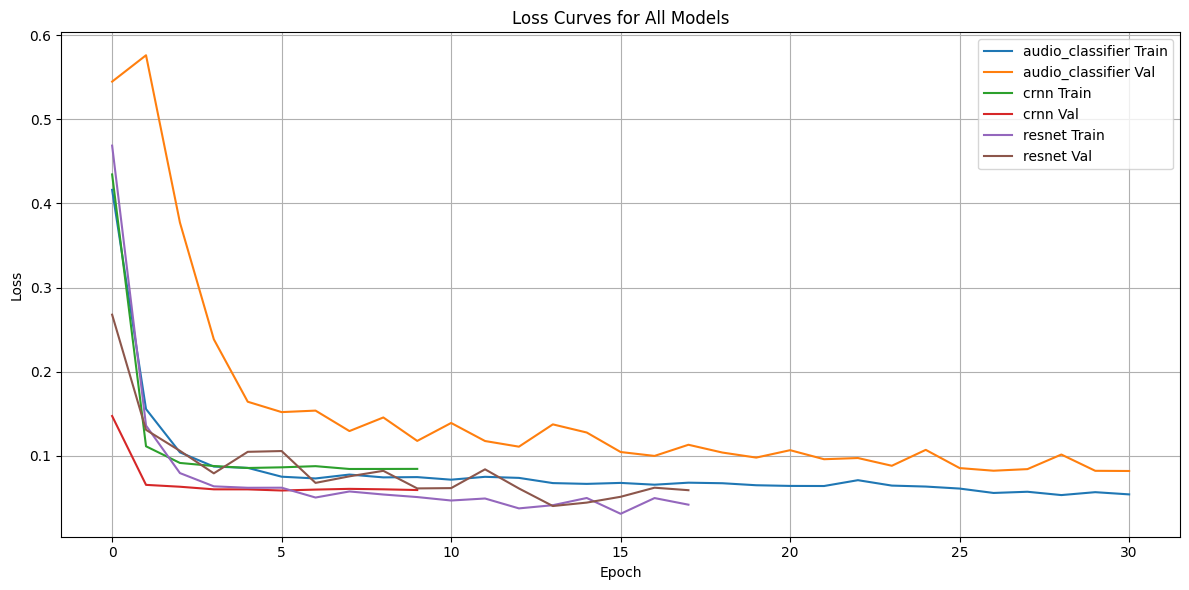

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define model names and base directory
models = ['audio_classifier', 'crnn', 'resnet']
base_path = '/content/drive/MyDrive/chagas-challenge/model'

# Plotting all loss curves on the same plot
plt.figure(figsize=(12, 6))

for model_name in models:
    csv_path = os.path.join(base_path, f'{model_name}_loss_curve.csv')
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        plt.plot(df['train_loss'], label=f'{model_name} Train')
        plt.plot(df['val_loss'], label=f'{model_name} Val')
    else:
        print(f"Missing: {csv_path}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves for All Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [85]:
import os
import shutil

# Folders to clear
folders = [ "/content/drive/MyDrive/chagas-challenge/holdout_outputs"]

for folder in folders:
    if os.path.exists(folder):
        shutil.rmtree(folder)


print("✅ Cleared and recreated 'holdout_outputs' and 'holdout_outputs_hea'")


✅ Cleared and recreated 'holdout_outputs' and 'holdout_outputs_hea'


## Run

In [128]:
!python run_model.py -d /content/drive/MyDrive/chagas_datasets/val -m model -o /content/drive/MyDrive/chagas_challenge/holdout_outputs -v

Loading the Challenge model...
Finding the Challenge data...
Running the Challenge model on the Challenge data...
-   1/249: 00002_hr...
🔍 Model predictions:
audio_classifier: pred=1, prob=0.6848, weight=0.45
           crnn: pred=1, prob=0.9676, weight=0.10
         resnet: pred=0, prob=0.2608, weight=0.45

🧩 Final avg prob: 0.5074 → Prediction: 0
-   2/249: 00009_hr...
🔍 Model predictions:
audio_classifier: pred=1, prob=0.6937, weight=0.45
           crnn: pred=1, prob=0.9650, weight=0.10
         resnet: pred=1, prob=0.9554, weight=0.45

🧩 Final avg prob: 0.6340 → Prediction: 0
-   3/249: 00018_hr...
🔍 Model predictions:
audio_classifier: pred=1, prob=0.8802, weight=0.45
           crnn: pred=1, prob=0.9680, weight=0.10
         resnet: pred=0, prob=0.0217, weight=0.45

🧩 Final avg prob: 0.5009 → Prediction: 0
-   4/249: 00023_hr...
🔍 Model predictions:
audio_classifier: pred=1, prob=0.8441, weight=0.45
           crnn: pred=1, prob=0.9668, weight=0.10
         resnet: pred=0, prob=

## Test

In [129]:
!python evaluate_model.py -d /content/drive/MyDrive/chagas_datasets/val -o /content/drive/MyDrive/chagas-challenge/holdout_outputs -s scores.csv

In [130]:
import os
import numpy as np
from helper_code import load_text, get_label, get_probability

def load_predictions_and_labels(output_dir):
    labels = []
    probs = []

    for fname in sorted(os.listdir(output_dir)):
        if not fname.endswith('.txt'):
            continue

        path = os.path.join(output_dir, fname)
        content = load_text(path)

        try:
            label = get_label(content)
            prob = get_probability(content)
        except:
            continue  # Skip malformed files

        labels.append(label)
        probs.append(prob)

    return np.array(labels), np.array(probs)

labels, outputs = load_predictions_and_labels("/content/drive/MyDrive/chagas-challenge/holdout_outputs")
print(f"Loaded {len(labels)} samples")


Loaded 249 samples


In [131]:
from helper_code import compute_challenge_score

# Compute actual challenge score with default 10,000 permutations
score = compute_challenge_score(labels, outputs)
print(f"Challenge score (TPR @ top 5%): {score:.4f}")


Challenge score (TPR @ top 5%): 0.0524


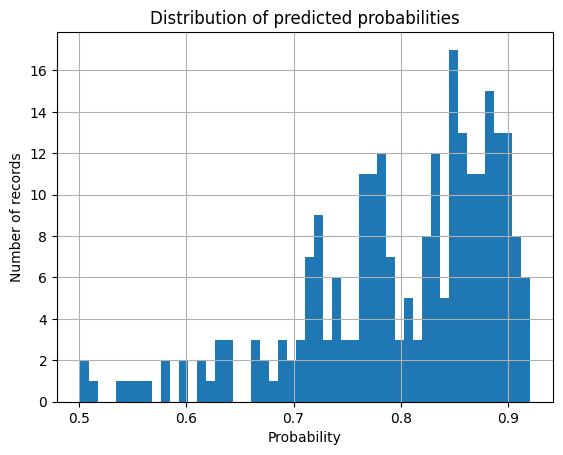

In [132]:
import matplotlib.pyplot as plt

plt.hist(outputs, bins=50)
plt.title("Distribution of predicted probabilities")
plt.xlabel("Probability")
plt.ylabel("Number of records")
plt.grid(True)
plt.show()


In [133]:
# Capacity is 5% of total records
capacity = int(0.05 * len(labels))
top_k_indices = np.argsort(outputs)[::-1][:capacity]

# Debug: Show top-k records and if they are positive
for idx in top_k_indices:
    print(f"Index {idx}: prob={outputs[idx]:.4f}, label={labels[idx]}")


Index 31: prob=0.9205, label=1
Index 55: prob=0.9194, label=1
Index 50: prob=0.9171, label=1
Index 57: prob=0.9169, label=1
Index 92: prob=0.9158, label=1
Index 149: prob=0.9158, label=1
Index 201: prob=0.9118, label=1
Index 26: prob=0.9071, label=1
Index 78: prob=0.9070, label=1
Index 205: prob=0.9067, label=1
Index 197: prob=0.9064, label=1
Index 153: prob=0.9059, label=1


In [127]:
# Indices of all true positive samples
tp_indices = np.where(labels == 1)[0]

# Find which of them are NOT in top_k
missed_tp = [idx for idx in tp_indices if idx not in top_k_indices]

print(f"Missed true positives (not in top 5%): {len(missed_tp)}")
for idx in missed_tp:
    print(f"Index {idx}: prob={outputs[idx]:.4f}")


Missed true positives (not in top 5%): 181
Index 6: prob=0.6999
Index 8: prob=0.6764
Index 10: prob=0.6688
Index 14: prob=0.6748
Index 17: prob=0.6775
Index 21: prob=0.6541
Index 27: prob=0.6889
Index 28: prob=0.7188
Index 30: prob=0.7378
Index 32: prob=0.7667
Index 33: prob=0.7399
Index 36: prob=0.6832
Index 37: prob=0.7228
Index 38: prob=0.7675
Index 39: prob=0.7820
Index 41: prob=0.7210
Index 42: prob=0.7478
Index 44: prob=0.6784
Index 48: prob=0.6870
Index 49: prob=0.7677
Index 53: prob=0.7759
Index 54: prob=0.7931
Index 56: prob=0.7887
Index 58: prob=0.6730
Index 59: prob=0.6947
Index 61: prob=0.7177
Index 62: prob=0.7204
Index 63: prob=0.7911
Index 64: prob=0.7931
Index 65: prob=0.7689
Index 67: prob=0.6745
Index 68: prob=0.7478
Index 69: prob=0.7396
Index 70: prob=0.7534
Index 71: prob=0.6600
Index 72: prob=0.7706
Index 73: prob=0.7670
Index 74: prob=0.7212
Index 75: prob=0.7147
Index 76: prob=0.7062
Index 77: prob=0.6991
Index 80: prob=0.7469
Index 82: prob=0.6625
Index 83: pro

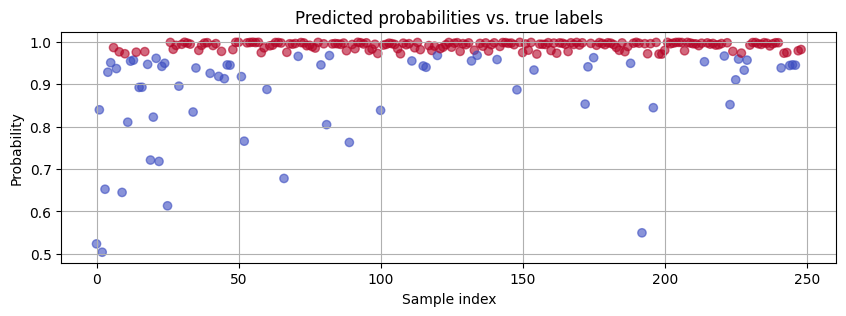

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.scatter(range(len(outputs)), outputs, c=labels, cmap='coolwarm', alpha=0.6)
plt.title("Predicted probabilities vs. true labels")
plt.xlabel("Sample index")
plt.ylabel("Probability")
plt.grid(True)
plt.show()


In [2]:
!git init


hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [12]:
!git config --global user.email "iskaareolssoen@gmail.com"

In [13]:
!git config --global user.name "IngeborgOlssoen"


In [14]:
!git branch


* Slimmed-models
  hear-heart
  main


In [17]:
!git checkout Slimmed-models


M	__pycache__/base_model.cpython-311.pyc
M	__pycache__/helper_code.cpython-311.pyc
M	__pycache__/team_code.cpython-311.pyc
M	base_model.py
M	model/audio_classifier_model.pt
M	model/crnn_model.pt
D	model/model.pt
M	model/resnet_model.pt
M	scores.csv
M	team_code.py
Already on 'Slimmed-models'
Your branch is up to date with 'origin/Slimmed-models'.


In [18]:
!git add .
!git commit -m "Have slimmed down the models to fit more our task. Early stopping, augmentation, randomsampler. Have implemned a temperature scaler which will downscale the confidence level. T=3 should be fine. NEXT: Look at different methods to scale the confidence down. we want to prioritize into the ones that needs to be check the fastest(?) from my understanding."


[Slimmed-models 11bb8e2] Have slimmed down the models to fit more our task. Early stopping, augmentation, randomsampler. Have implemned a temperature scaler which will downscale the confidence level. T=3 should be fine. NEXT: Look at different methods to scale the confidence down. we want to prioritize into the ones that needs to be check the fastest(?) from my understanding.
 264 files changed, 2100 insertions(+), 609 deletions(-)
 rewrite __pycache__/base_model.cpython-311.pyc (94%)
 rewrite __pycache__/team_code.cpython-311.pyc (96%)
 rewrite base_model.py (89%)
 create mode 100644 detailed_scores.csv
 create mode 100644 holdout_outputs/00002_hr.txt
 create mode 100644 holdout_outputs/00009_hr.txt
 create mode 100644 holdout_outputs/00018_hr.txt
 create mode 100644 holdout_outputs/00023_hr.txt
 create mode 100644 holdout_outputs/102640.txt
 create mode 100644 holdout_outputs/105443.txt
 create mode 100644 holdout_outputs/106689.txt
 create mode 100644 holdout_outputs/107019.txt
 cre

In [21]:
# 1. Unstage all .txt files from the commit
!git reset HEAD^ -- '*.txt'


In [23]:
# 2. Recommit without the .txt files
!git commit -m "Recommit without .txt files"

[Slimmed-models 50ff984] Recommit without .txt files
 249 files changed, 498 deletions(-)
 delete mode 100644 holdout_outputs/00002_hr.txt
 delete mode 100644 holdout_outputs/00009_hr.txt
 delete mode 100644 holdout_outputs/00018_hr.txt
 delete mode 100644 holdout_outputs/00023_hr.txt
 delete mode 100644 holdout_outputs/102640.txt
 delete mode 100644 holdout_outputs/105443.txt
 delete mode 100644 holdout_outputs/106689.txt
 delete mode 100644 holdout_outputs/107019.txt
 delete mode 100644 holdout_outputs/109838.txt
 delete mode 100644 holdout_outputs/112408.txt
 delete mode 100644 holdout_outputs/132616.txt
 delete mode 100644 holdout_outputs/138534.txt
 delete mode 100644 holdout_outputs/138704.txt
 delete mode 100644 holdout_outputs/141879.txt
 delete mode 100644 holdout_outputs/142852.txt
 delete mode 100644 holdout_outputs/149836.txt
 delete mode 100644 holdout_outputs/150382.txt
 delete mode 100644 holdout_outputs/153126.txt
 delete mode 100644 holdout_outputs/163723.txt
 delete m

In [24]:
!echo "*.txt" >> .gitignore


In [25]:
!git add .gitignore
!git commit -m "Update .gitignore to exclude .txt files"


[Slimmed-models 866d371] Update .gitignore to exclude .txt files
 1 file changed, 1 insertion(+)


In [28]:
!git config pull.rebase false


In [30]:
!git reset --soft HEAD^



In [31]:
!git reset HEAD -- '*.txt'


In [32]:
!git commit -m "Recommit without .txt files"


[Slimmed-models 579c785] Recommit without .txt files
 1 file changed, 1 insertion(+)


In [33]:
!git push origin Slimmed-models --force


Enumerating objects: 274, done.
Counting objects: 100% (274/274), done.
Delta compression using up to 2 threads
Compressing objects: 100% (23/23), done.
Writing objects: 100% (263/263), 83.73 MiB | 8.24 MiB/s, done.
Total 263 (delta 6), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (6/6), completed with 4 local objects.
remote: warning: See https://gh.io/lfs for more information.
remote: warning: File model/resnet_model.pt is 90.00 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To https://github.com/IngeborgOlssoen/Chagas-challenge-Hear-heart.git
 + 88193c4...579c785 Slimmed-models -> Slimmed-models (forced update)
